# Identification of USB type with ML

In [1]:
%matplotlib inline

from PIL import Image
import numpy, os
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import RidgeCV

from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.transform import resize
from skimage.measure import regionprops
from skimage.morphology import binary_erosion, binary_dilation, binary_opening
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import LabelEncoder
import time


## Importing and preprocessing images
Because a self-made data set is used preprocessing is an extra important step to get good results.
All images first get their bottom and top cropped because of a common flaw discovered after the pictures were taken.
Afterwards images get scaled and converted to grayscale.
Dilation is used on an inverted image to better recognize the region of interest as a single region.

In [2]:
def importimage(filename):
    image = imread(filename, as_gray=True)
    # crop top and bottom 100 pixels
    image = image[100:620, 0:405]

    gray_image_scaled = image * 255

    threshold_value = threshold_otsu(gray_image_scaled)
    binary_image = gray_image_scaled > threshold_value
 
    binary_image = numpy.invert(binary_image)

    # Dilate image to ensure that small parts of the usb are recognized as one object
    binary_image = binary_dilation(binary_image)
    binary_image = binary_dilation(binary_image)
    binary_image = binary_dilation(binary_image)

    label_image = measure.label(binary_image)

    minx = 9999
    miny = 9999
    maxx = 0 
    maxy = 0
    for region in regionprops(label_image):
        if region.area < 500:
            # remove too small areas
            continue
        
        # the bounding box coordinates
        minRow, minCol, maxRow, maxCol = region.bbox
        if (minx > minCol):
            minx = minCol
        if (miny > minRow):
            miny = minRow
        if (maxx < maxCol):
            maxx = maxCol
        if (maxy < maxRow):
            maxy = maxRow

    width = maxx - minx
    height = maxy - miny    

    resize_width = 64
    resize_height = 64

    if (width > height):
        miny -= (width - height) / 2
        maxy += (width - height) / 2
    if (height > width):
        minx -= (height - width) / 2
        maxx += (height - width) / 2

    cropped_image = gray_image_scaled[int(miny):int(maxy), int(minx):int(maxx)]
    try:
        scaled_cropped_image = resize(cropped_image, (resize_width, resize_height), 
                                      anti_aliasing=False, mode='constant')
    except:
        return None

    return scaled_cropped_image

## Labeling of images
The images have been pre-sorted into categories based on a directory structure. Labelling images is done simply by looping through the directories and fetching the image and directory name.

In [37]:
path="frames/"
labels = []
imgs = []
for directory in os.listdir(path):
    for directory2 in os.listdir(path+directory):
        for file in os.listdir(path+directory+"/"+directory2):
#            print(path+directory+"/"+directory2+"/"+file)
            img = importimage(path+directory+"/"+directory2+"/"+file)
            if img is not None:
                labels.append(directory)
                imgs.append(img.reshape(-1))
            # exit(0)

print("Imported {} images.".format(len(imgs)))
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.5, random_state=42)

NameError: name 'Path' is not defined

## Classification methods
### Linear Support Vector Classification
Because of our relatively limited dataset our first pick was linear SVC.

In [4]:
from sklearn.svm import SVC

t0 = time.time()
print("SVC linear")
svc_model = SVC(kernel='linear', probability=True)
svc_model.fit(X_train, y_train)
result = svc_model.predict(X_test)
correct = 0
wrong = 0
for i in range(0, len(X_test)):
    if(y_test[i] == result[i]):
        correct += 1
    else:
        wrong += 1
print("Accuracy: {}% ({}/{})".format(correct / (correct + wrong) * 100, correct, correct + wrong))
print("Time taken: {} seconds.".format(time.time() - t0))

SVC linear
Accuracy: 99.74734714502273% (1974/1979)
Time taken: 60.95750713348389 seconds.


### Decision tree


In [5]:
from sklearn.tree import DecisionTreeClassifier

t0 = time.time()
print("DecisionTreeClassifier")
dtf = DecisionTreeClassifier(random_state=42)
dtf.fit(X_train, y_train)
result = dtf.predict(X_test)
correct = 0
wrong = 0
for i in range(0, len(X_test)):
    if(y_test[i] == result[i]):
        correct += 1
    else:
        wrong += 1
print("Accuracy: {}% ({}/{})".format(correct / (correct + wrong) * 100, correct, correct + wrong))
print("Time taken: {} seconds.".format(time.time() - t0))

DecisionTreeClassifier
Accuracy: 91.61192521475493% (1813/1979)
Time taken: 5.36196756362915 seconds.


### KNeighbors
Our most successful method based on both accuracy and time is K-nearest neighbors. It's a lazy method which takes little time to train. It makes no internal model and instead stores all the training data. 
A match is found by a majority vote using the stored data to find the closest other match.

KNeighbor
Accuracy: 99.39363314805458% (1967/1979)
Time taken: 22.930851697921753 seconds.


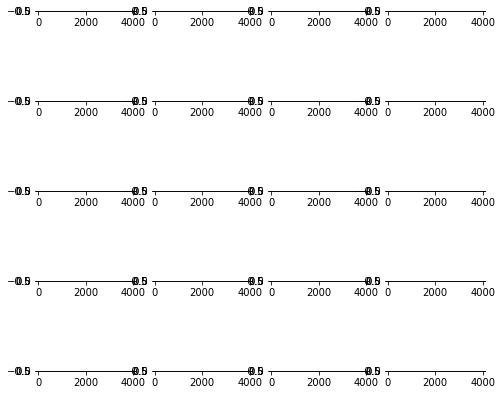

In [7]:
from sklearn.neighbors import KNeighborsClassifier

t0 = time.time()
print("KNeighbor")
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(X_train, y_train)
result = knc.predict(X_test)
correct = 0
wrong = 0
for i in range(0, len(X_test)):
    if(y_test[i] == result[i]):
        correct += 1
    else:
        wrong += 1
print("Accuracy: {}% ({}/{})".format(correct / (correct + wrong) * 100, correct, correct + wrong))
print("Time taken: {} seconds.".format(time.time() - t0))


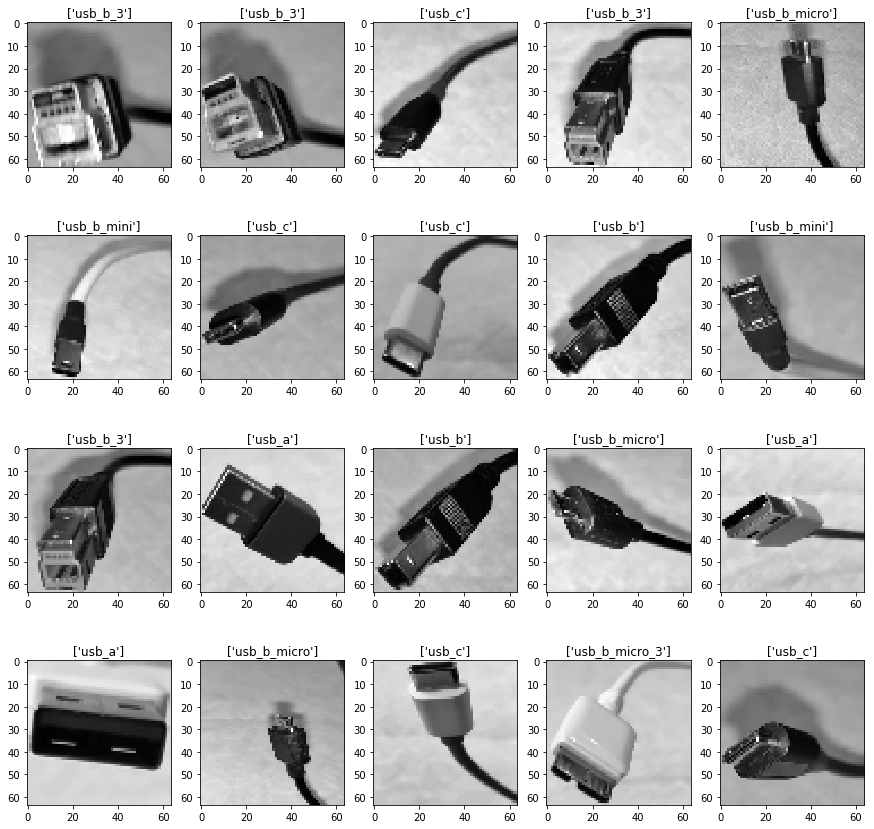

In [71]:

import random

columns = 5
rows = 4
ax = []
fig = plt.figure(figsize=(15, 15))


for i in range( columns*rows ):
    sample = random.choice(imgs)
    img =  sample.reshape(64, 64) # get a random image and read it
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1))
    # result = knc.predict(sample)
    prediction = knc.predict(sample.reshape(1, -1))
    ax[-1].set_title(str( str(prediction) ))  # set title to label
    plt.imshow(img, cmap='gray')

plt.show() 